In [256]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Load the data

In [257]:
!mkdir data && wget https://github.com/sdip15fa/weather-predict/raw/master/data/processed_data.csv -O data/processed_data.csv

input_file = 'data/processed_data.csv'
df = pd.read_csv('data/processed_data.csv',
                 parse_dates=['DateTime'], index_col='DateTime')
df = df.resample('60T').mean()
# df["DateTime"] = pd.to_datetime(df.index)
df = df.reset_index()

mkdir: cannot create directory ‘data’: File exists


Convert the 'Date' and 'Time' columns to integers

In [258]:
df["Temperature"] = df["Temperature"].astype(float)
df["Wind Speed"] = df["Wind Speed"].astype(float)
df["Rainfall"] = df["Rainfall"].astype(float)
df["Wind Direction"] = df["Wind Direction"].astype(float)
df["Humidity"] = df["Humidity"].astype(float)

Filter and replace outliers

In [259]:
df['Temperature'] = df['Temperature'].replace(3276.7, np.nan)
df['Wind Speed'] = df['Wind Speed'].replace(32767, np.nan)
df['Rainfall'] = df['Rainfall'].replace(32767, np.nan)
df['Wind Direction'] = df['Wind Direction'].replace(32767, np.nan)
df['Humidity'] = df['Humidity'].replace(32767, np.nan)
df['Temperature'] = df['Temperature'].mask((df['Temperature'] > 40) | (df['Temperature'] < -10), np.nan)
df['Wind Speed'] = df['Wind Speed'].mask((df['Wind Speed'] > 200) | df["Wind Speed"] < 0, np.nan)
df['Rainfall'] = df['Rainfall'].mask((df['Rainfall'] > 100)| df["Rainfall"] < 0, np.nan)
df['Wind Direction'] = df['Wind Direction'].mask((df['Wind Direction'] < 0) | (df['Wind Direction'] > 360), np.nan)
df['Humidity'] = df['Humidity'].mask((df['Humidity'] < 0) | (df['Humidity'] > 100), np.nan)

In [260]:
df[df.isna().any(axis=1)]

,DateTime,Year,Month,Date,Time,Minute,Temperature,Wind Speed,Wind Direction,Rainfall,Humidity
36,2008-01-02 12:00:00,2008.0,1.0,2.0,12.0,1.0,NaN,NaN,NaN,NaN,NaN
38,2008-01-02 14:00:00,2008.0,1.0,2.0,14.0,1.0,11.2,19.0,NaN,0.0,27.0
39,2008-01-02 15:00:00,2008.0,1.0,2.0,15.0,1.0,10.7,13.0,NaN,0.0,31.0
59,2008-01-03 11:00:00,2008.0,1.0,3.0,11.0,1.0,11.9,15.0,NaN,0.0,36.0
111,2008-01-05 15:00:00,2008.0,1.0,5.0,15.0,1.0,16.0,10.0,NaN,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...
134727,2023-05-15 15:00:00,2023.0,5.0,15.0,15.0,1.0,NaN,19.0,26.0,0.0,NaN
134728,2023-05-15 16:00:00,2023.0,5.0,15.0,16.0,1.0,NaN,1.0,265.0,0.0,NaN
135060,2023-05-29 12:00:00,2023.0,5.0,29.0,12.0,1.0,NaN,41.0,273.0,0.0,NaN
135109,2023-05-31 13:00:00,2023.0,5.0,31.0,13.0,1.0,27.4,13.0,NaN,0.0,88.0


In [261]:
df = df.fillna(method="ffill")

Prepare the data for LSTM

Remove rows with missing values

In [262]:
df = df.dropna().reset_index()

In [263]:
df

,index,DateTime,Year,Month,Date,Time,Minute,Temperature,Wind Speed,Wind Direction,Rainfall,Humidity
0,0,2008-01-01 00:00:00,2008.0,1.0,1.0,0.0,1.0,3.6,107.0,49.0,0.0,37.0
1,1,2008-01-01 01:00:00,2008.0,1.0,1.0,1.0,1.0,3.0,103.0,42.0,0.0,35.0
2,2,2008-01-01 02:00:00,2008.0,1.0,1.0,2.0,1.0,2.3,101.0,39.0,0.0,37.0
3,3,2008-01-01 03:00:00,2008.0,1.0,1.0,3.0,1.0,2.4,92.0,47.0,0.0,33.0
4,4,2008-01-01 04:00:00,2008.0,1.0,1.0,4.0,1.0,2.0,102.0,47.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...
135847,135847,2023-07-01 07:00:00,2023.0,7.0,1.0,7.0,1.0,22.3,61.0,211.0,30.0,100.0
135848,135848,2023-07-01 08:00:00,2023.0,7.0,1.0,8.0,1.0,22.3,62.0,210.0,80.0,100.0
135849,135849,2023-07-01 09:00:00,2023.0,7.0,1.0,9.0,1.0,20.7,82.0,223.0,35.0,100.0
135850,135850,2023-07-01 10:00:00,2023.0,7.0,1.0,10.0,1.0,22.0,55.0,241.0,10.0,100.0


Check if any hours are missing

In [264]:
# Get the minimum and maximum DateTime values in the DataFrame
min_time = df['DateTime'].min()
max_time = df['DateTime'].max()

# Create a complete sequence of hours using pandas date_range
complete_hours = pd.date_range(start=min_time, end=max_time, freq='H')

# Extract the unique hours from the DataFrame
existing_hours = pd.to_datetime(df['DateTime']).unique()

# Find the missing hours by comparing the complete sequence with the existing hours
missing_hours = [hour for hour in complete_hours if hour not in existing_hours]

# Print the missing hours
print(missing_hours)

[]


In [265]:
time_steps = 72  # Number of time steps for the LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale the data to [0, 1]

In [266]:
features_keys = ['Temperature', 'Wind Speed',
               'Rainfall', 'Humidity']

Scale the temperature, wind speed, rainfall, and wind direction values

In [267]:
features = df[features_keys].copy()
scaled_features = scaler.fit_transform(features)

In [268]:
scaled_features

array([[0.27350427, 0.21572581, 0.        , 0.34375   ],
       [0.25641026, 0.20766129, 0.        , 0.32291667],
       [0.23646724, 0.20362903, 0.        , 0.34375   ],
       ...,
       [0.76068376, 0.16532258, 0.03888889, 1.        ],
       [0.7977208 , 0.1108871 , 0.01111111, 1.        ],
       [0.82336182, 0.11693548, 0.        , 1.        ]])

Create sequences of input data and corresponding target values

In [269]:
data = []
target = []
for i in range(1, len(scaled_features) - time_steps):
    # exclude the target
    data.append(scaled_features[i:i+time_steps])
    # Only the temperature is the target
    target.append(scaled_features[i+time_steps])

In [270]:
data = np.array(data)
target = np.array(target)


Split the dataset into training and validation sets

In [271]:
split = 0.1
exclude_index = int(len(data) * (1-split))
train_data, train_target = data[:exclude_index], target[:exclude_index]
val_data, val_target = data[exclude_index:], target[exclude_index:]


Build the LSTM model architecture

In [272]:
import tensorflow as tf
"""
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True,
                         input_shape=(time_steps, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
"""
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256,  input_shape=(time_steps, len(features_keys))),
    # tf.keras.layers.LSTM(128, return_sequences=True),
    # tf.keras.layers.LSTM(64),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.LSTM(32, return_sequences=True),
    # tf.keras.layers.LSTM(128, return_sequences=True),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.LSTM(64),
    # tf.keras.layers.Dense(64),
    # tf.keras.layers.Dense(64),
    # tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(len(features_keys))
])


Compile the model

In [273]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', optimizer=optimizer)

Define early stopping and learning rate scheduler

In [274]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Train the LSTM model

In [275]:
batch_size = 4096
epochs = 100
history = model.fit(train_data, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_target),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
30/30 [==============================] - 9s 203ms/step - loss: 0.1247 - val_loss: 0.0614 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 6s 192ms/step - loss: 0.0458 - val_loss: 0.0397 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - 6s 194ms/step - loss: 0.0341 - val_loss: 0.0344 - lr: 0.0010
Epoch 4/100
30/30 [==============================] - 6s 194ms/step - loss: 0.0304 - val_loss: 0.0306 - lr: 0.0010
Epoch 5/100
30/30 [==============================] - 6s 194ms/step - loss: 0.0299 - val_loss: 0.0285 - lr: 0.0010
Epoch 6/100
30/30 [==============================] - 6s 195ms/step - loss: 0.0290 - val_loss: 0.0273 - lr: 0.0010
Epoch 7/100
30/30 [==============================] - 6s 199ms/step - loss: 0.0270 - val_loss: 0.0269 - lr: 0.0010
Epoch 8/100
30/30 [==============================] - 6s 198ms/step - loss: 0.0255 - val_loss: 0.0246 - lr: 0.0010
Epoch 9/100
30/30 [==============================] - 6s 198ms/step - loss: 0.0237 - val_

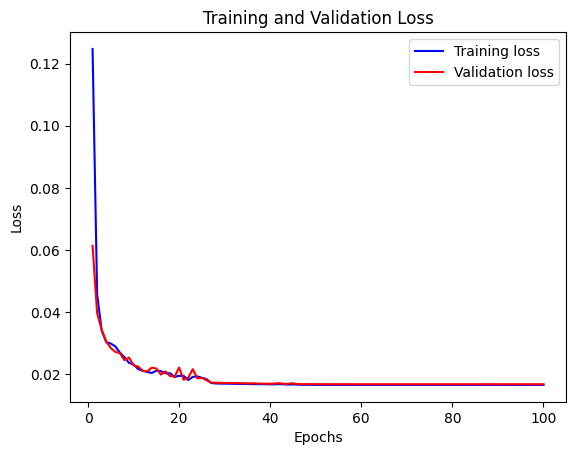

In [276]:
# Access the loss values from the training history
train_losses = history.history['loss']
val_losses = history.history['val_loss']

# Plot the loss values
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Make predictions using the trained LSTM model

In [277]:
predictions = model.predict(val_data)

425/425 [==============================] - 2s 3ms/step


Rescale the predictions back to the original range

In [278]:
scaled_predictions = pd.DataFrame(predictions, columns=features_keys)
predictions = pd.DataFrame(scaler.inverse_transform(
    predictions), columns=features_keys)
predicted_temperature = predictions["Temperature"]


In [279]:
val_target = pd.DataFrame(val_target, columns=features_keys)
val_target_rescaled = pd.DataFrame(scaler.inverse_transform(val_target), columns=features_keys)
train_target = pd.DataFrame(train_target, columns=features_keys)
train_target_rescaled = pd.DataFrame(scaler.inverse_transform(train_target), columns=features_keys)

Calculate MSE and MAE

In [280]:
mse = mean_squared_error(val_target_rescaled["Temperature"], predictions["Temperature"])
mae = mean_absolute_error(val_target_rescaled["Temperature"], predictions["Temperature"])

In [281]:
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.5776842965069174
Mean Absolute Error (MAE): 0.5209971749575363


Visualize the actual vs. predicted temperatures for the validation set

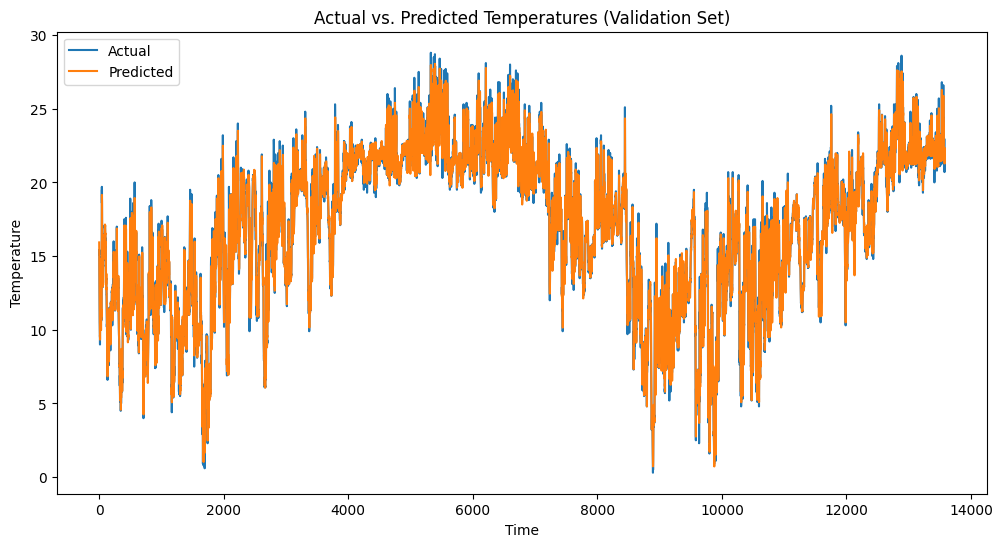

In [282]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(val_target)), val_target_rescaled["Temperature"], label='Actual')
plt.plot(range(len(val_target)), predicted_temperature, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Validation Set)')
plt.legend()
plt.show()

Visualize the actual vs. predicted temperatures for the training set

3819/3819 [==============================] - 12s 3ms/step


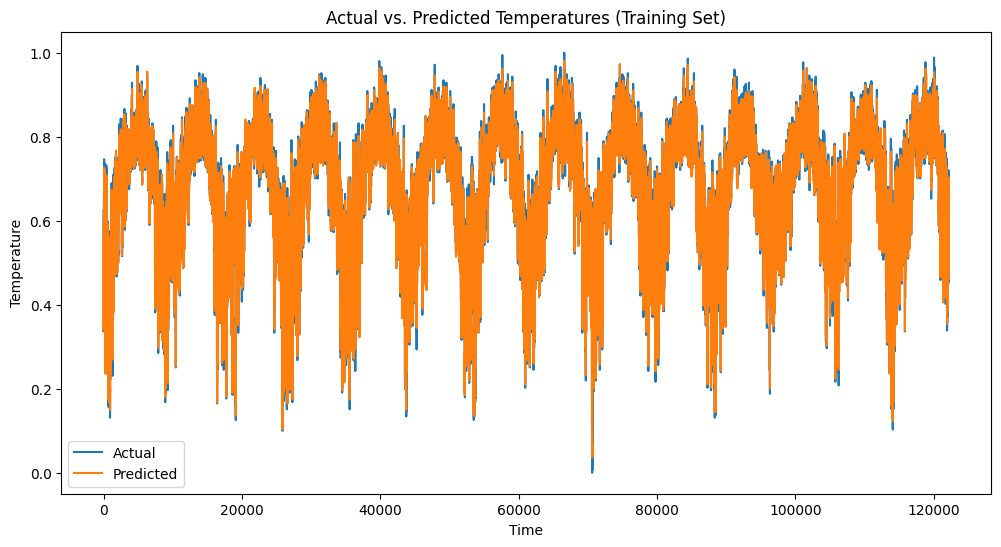

In [283]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_target)), train_target["Temperature"], label='Actual')
plt.plot(range(len(train_target)), pd.DataFrame(model.predict(
    train_data), columns=features_keys)["Temperature"], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Training Set)')
plt.legend()
plt.show()

Save the trained model

In [284]:
model.save("lstm.keras")

In [285]:
scaled_features
scaled_features.copy()[-time_steps:].shape

(72, 4)

In [286]:
from datetime import timedelta
model = tf.keras.models.load_model("lstm.keras")

data = scaled_features.copy()[-time_steps:]
predicted = []

for i in range(1, 31):
    scaled_prediction = model.predict(data.reshape(1, time_steps, len(features_keys)))
    prediction = scaler.inverse_transform(scaled_prediction)[0]
    print(f'{df["DateTime"].max() + timedelta(hours=i)}:', list(map(lambda x: round(x, 6), prediction)))
    # print(prediction[0], data, np.append(data, prediction[0]))
    data = np.vstack((data, scaled_prediction))
    data = np.delete(data, 0, axis=0)
    predicted.append(prediction)

1/1 [==============================] - 0s 369ms/step
2023-07-01 12:00:00: [22.550945, 53.815166, 4.759492, 99.0128]
1/1 [==============================] - 0s 23ms/step
2023-07-01 13:00:00: [22.652237, 51.71282, 3.286279, 99.12422]
1/1 [==============================] - 0s 24ms/step
2023-07-01 14:00:00: [22.702951, 50.568645, 2.220628, 99.21788]
1/1 [==============================] - 0s 26ms/step
2023-07-01 15:00:00: [22.715454, 50.1679, 1.465924, 99.287415]
1/1 [==============================] - 0s 28ms/step
2023-07-01 16:00:00: [22.701553, 50.294098, 0.942494, 99.34225]
1/1 [==============================] - 0s 28ms/step
2023-07-01 17:00:00: [22.6711, 50.75142, 0.588144, 99.39108]
1/1 [==============================] - 0s 28ms/step
2023-07-01 18:00:00: [22.631865, 51.378326, 0.354574, 99.438705]
1/1 [==============================] - 0s 26ms/step
2023-07-01 19:00:00: [22.589655, 52.0528, 0.205065, 99.486725]
1/1 [==============================] - 0s 27ms/step
2023-07-01 20:00:00: [22.

In [287]:
results = pd.DataFrame(predicted, columns=features_keys)
results.insert(0, "DateTime", [df["DateTime"].max() + timedelta(hours=i) for i in range(1, 31)])
results.to_csv("predict.csv")

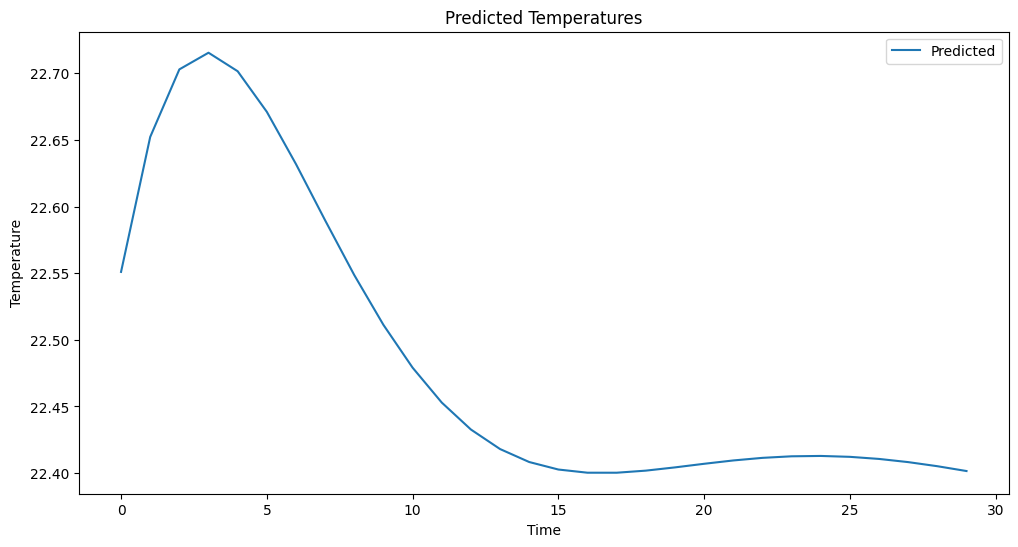

In [288]:
plt.figure(figsize=(12, 6))
plt.plot(range(30), np.array(predicted)[:, 0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Predicted Temperatures')
plt.legend()
plt.show()